In [1]:
### ATOC5860 - response_function_moving_avg
### Originally from Libby Barnes (Colorado State University)
### Additional commenting/code from Jennifer Kay (University of Colorado)
### Last updated March 21, 2022

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import scipy.signal as sig
from matplotlib.gridspec import GridSpec
import timeit
import scipy.io as sio

In [2]:
## create data
t = np.arange(1,40)
#print(len(t))
x = np.zeros(np.shape(t))
foo=round(np.size(t)/2)
foo1=round(foo+2)
x[foo:foo1] = np.ones((2,))

In [3]:
### Smooth data in the time domain

## you can try different response functions here
#responsefunction='111'
responsefunction='121'

if responsefunction=='111':
    g = [1.,1.,1.] ## run mean 3 (1-1-1)
    g_fractions = [1/3.,1/3.,1/3.]

if responsefunction=='121':
    g = [1.,2.,1.] ## 1-2-1
    g_fractions = [1/4.,1/2.,1/4.]

## Filter in the time domain: apply smoothing, with this we actually lose data at the end as we expected to...
y1_valid = np.convolve(g_fractions,x,'valid')
print(y1_valid.shape)

## Filter in the time domain: apply smoothing, with padding to be in the center
### this one agrees with theoretical calculation as originally coded
y1_same = np.convolve(g_fractions,x,'same')
print(y1_same.shape)

y1_full = np.convolve(g_fractions,x,'full') ### this is the default for np.convolve
print(y1_full.shape)
t_full = np.arange(1,42)

## Filter in the time domain: apply smoothing twice (forward/backward)
y2_filtfilt = sig.filtfilt(g,np.sum(g),x)
print(y2_filtfilt.shape)

y2_convolve = np.convolve(g_fractions,np.convolve(g_fractions,x,'same'),'same')
print(y2_convolve.shape)

print(t[:-2].shape)
print(t.shape)

(37,)
(39,)
(41,)
(39,)
(39,)
(37,)
(39,)


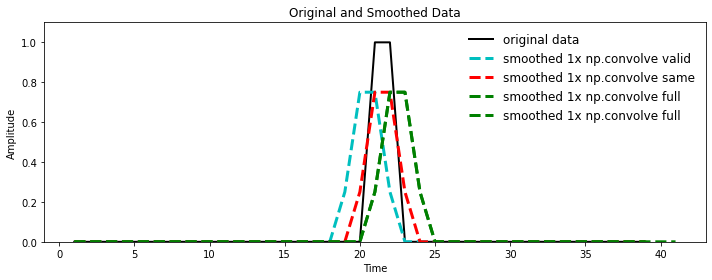

In [4]:
f=plt.figure(figsize=(10,4))
plt.title('Original and Smoothed Data');
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.plot(t,x,'-k',linewidth = 2, label ='original data');
plt.plot(t[:-2],y1_valid,'--c',linewidth = 3, label = 'smoothed 1x np.convolve valid' );
plt.plot(t,y1_same,'--r',linewidth = 3, label = 'smoothed 1x np.convolve same' );
plt.plot(t_full,y1_full,'--g',linewidth = 3, label = 'smoothed 1x np.convolve full' );
plt.plot(t,y1_full[0:len(t)],'--g',linewidth = 3, label = 'smoothed 1x np.convolve full' );
plt.ylim(0,1.1);
plt.legend(fontsize = 12, frameon = False, loc='upper right');
f.tight_layout()

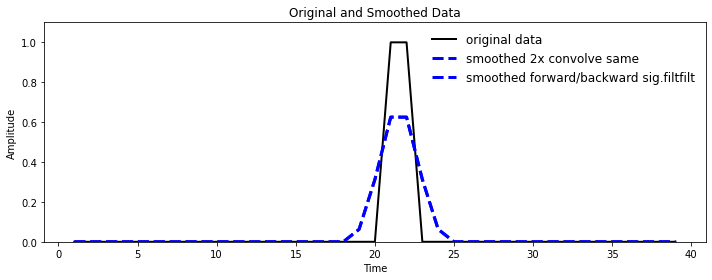

In [5]:
f=plt.figure(figsize=(10,4))
plt.title('Original and Smoothed Data');
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.plot(t,x,'-k',linewidth = 2, label ='original data');
plt.plot(t,y2_convolve,'--b',linewidth = 3, label = 'smoothed 2x convolve same' );
plt.plot(t,y2_filtfilt,'--b',linewidth = 3, label = 'smoothed forward/backward sig.filtfilt' );
plt.ylim(0,1.1);
plt.legend(fontsize = 12, frameon = False, loc='upper right');
f.tight_layout()

In [6]:
### Pick the smoothed data that you want to use as input to spectral analysis
y1=y1_same
y2=y2_convolve

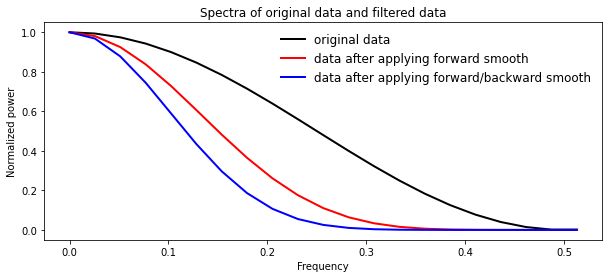

In [7]:
## Calculate the power spectra of original and filtered data
Z_x = np.fft.fft(x)/np.size(x)
Z_y1 = np.fft.fft(y1)/np.size(y1)
Z_y2 = np.fft.fft(y2)/np.size(y2)

Ck2_x = np.abs(Z_x[0:round(np.size(Z_x)/2) + 1])**2
Ck2_y1 = np.abs(Z_y1[0:round(np.size(Z_x)/2) + 1])**2
Ck2_y2 = np.abs(Z_y2[0:round(np.size(Z_x)/2) + 1])**2

freq = np.arange(0,np.size(x)/2+1)/float(np.size(x))

### Plot power spectra of the data and filtered data

f=plt.figure(figsize=(10,4))
plt.title('Spectra of original data and filtered data');
maxval = np.max(Ck2_x)
plt.plot(freq,Ck2_x/maxval,'-k',linewidth = 2, label = 'original data');
maxval = np.max(Ck2_y1)
plt.plot(freq,Ck2_y1/maxval,'-r',linewidth = 2, label = 'data after applying forward smooth');
maxval = np.max(Ck2_y2)
plt.plot(freq,Ck2_y2/maxval,'-b',linewidth = 2, label = 'data after applying forward/backward smooth');
plt.legend(fontsize = 12, frameon = False, loc='upper right');
plt.xlabel('Frequency');
plt.ylabel('Normalized power');

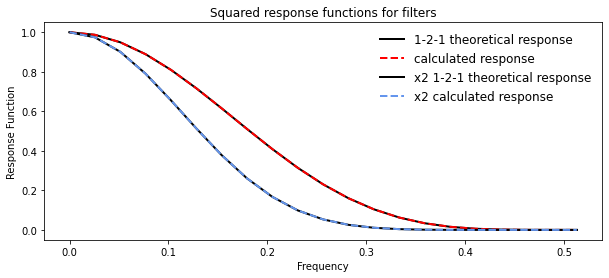

In [8]:
## Find the response function of the filters -- Barnes Equations 94-96
freq = np.arange(0,round(np.size(Z_x)/2)+1)/float(np.size(x))

if responsefunction=='111':
    ## Theoretical Response Function 1-1-1
    Rg_y1 = 1./3 + (2./3)*np.cos(freq*2.*np.pi)  ## Barnes Eq. 100 page 26 Chapter 4
    Rg_y2 = (1./3 + (2./3)*np.cos(freq*2*np.pi))**2
    label1 = '1-1-1 theoretical response'
    label2 = '1-1-1 x2 theoretical response'

if responsefunction=='121':
    ## Theoretical Response Function 1-2-1  ## Barnes Eq. 108 page 26 Chapter 4
    Rg_y1 = 1./2 + (1./2)*np.cos(freq*2.*np.pi)
    Rg_y2 = (1./2 + (1./2)*np.cos(freq*2*np.pi))**2
    label1 = '1-2-1 theoretical response'
    label2 = 'x2 1-2-1 theoretical response'
    
### Response Function
Rg2_y1 = Rg_y1**2
Rg2_y2 = Rg_y2**2

### Plot the response functions squared (to compare with directly with power C_k^2)
f=plt.figure(figsize=(10,4))
plt.title('Squared response functions for filters');
plt.plot(freq,Rg2_y1,'-k',linewidth = 2, label = label1);
plt.plot(freq,Ck2_y1/Ck2_x,'--r',linewidth = 2, label = 'calculated response');
plt.plot(freq,Rg2_y2,'-k',linewidth = 2, label = label2);
plt.plot(freq,Ck2_y2/Ck2_x,'--',color = 'cornflowerblue',linewidth = 2, label = 'x2 calculated response');
plt.legend(fontsize = 12, frameon = False,loc='upper right');
plt.ylabel('Response Function');
plt.xlabel('Frequency');